## [1] 모델정의

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

# PyTorch는 기본적으로 GPU 사용을 권장합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cuda


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # CIFAR-10: 3x32x32 입력
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)     # 8x8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10) # 10개 클래스
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## [2] 전처리설정_데이터 로더기

In [3]:
# 실험 1: 기본 정규화
transform_no_aug = transforms.Compose([
    transforms.ToTensor(),
    # CIFAR-10 평균과 표준편차
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset_no_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_no_aug)
trainloader_no_aug = DataLoader(trainset_no_aug, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_no_aug)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


In [4]:
# 실험 2: 데이터 증강 적용
# 증강은 train에만 적용합니다.
transform_with_aug = transforms.Compose([
    # 데이터 증강 기법 추가
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # 기본 정규화
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset_with_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_with_aug)
trainloader_with_aug = DataLoader(trainset_with_aug, batch_size=64, shuffle=True, num_workers=2)

## [3] 모델 훈련 실행

In [6]:
# 훈련 함수
def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 에폭마다 검증 정확도 측정
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        val_accuracies.append(acc)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Test Acc: {acc:.2f}%')

    return val_accuracies, 100 * correct / total

# 실험 설정
EPOCHS = 10

# --- 실험 1: 증강 없음 ---
print("\n###  실험 1: 데이터 증강 없이 훈련 ###")
model_no_aug = SimpleCNN().to(device)
val_acc_no_aug, final_acc_no_aug = train_model(model_no_aug, trainloader_no_aug, testloader, epochs=EPOCHS)


# --- 실험 2: 증강 적용 ---
print("\n###  실험 2: 데이터 증강 적용하여 훈련 ###")
model_with_aug = SimpleCNN().to(device)
val_acc_with_aug, final_acc_with_aug = train_model(model_with_aug, trainloader_with_aug, testloader, epochs=EPOCHS)


###  실험 1: 데이터 증강 없이 훈련 ###
Epoch [1/10], Loss: 1.3019, Test Acc: 62.79%
Epoch [2/10], Loss: 0.9329, Test Acc: 66.38%
Epoch [3/10], Loss: 0.7785, Test Acc: 70.02%
Epoch [4/10], Loss: 0.6621, Test Acc: 71.86%
Epoch [5/10], Loss: 0.5627, Test Acc: 71.95%
Epoch [6/10], Loss: 0.4718, Test Acc: 70.86%
Epoch [7/10], Loss: 0.3904, Test Acc: 71.76%
Epoch [8/10], Loss: 0.3146, Test Acc: 71.82%
Epoch [9/10], Loss: 0.2545, Test Acc: 70.73%
Epoch [10/10], Loss: 0.2046, Test Acc: 70.56%

###  실험 2: 데이터 증강 적용하여 훈련 ###
Epoch [1/10], Loss: 1.5349, Test Acc: 55.18%
Epoch [2/10], Loss: 1.1996, Test Acc: 62.93%
Epoch [3/10], Loss: 1.0724, Test Acc: 66.52%
Epoch [4/10], Loss: 0.9941, Test Acc: 68.16%
Epoch [5/10], Loss: 0.9395, Test Acc: 70.84%
Epoch [6/10], Loss: 0.8943, Test Acc: 72.09%
Epoch [7/10], Loss: 0.8612, Test Acc: 73.11%
Epoch [8/10], Loss: 0.8325, Test Acc: 72.37%
Epoch [9/10], Loss: 0.8147, Test Acc: 72.85%
Epoch [10/10], Loss: 0.7876, Test Acc: 73.47%


## [4] 결과 시각화

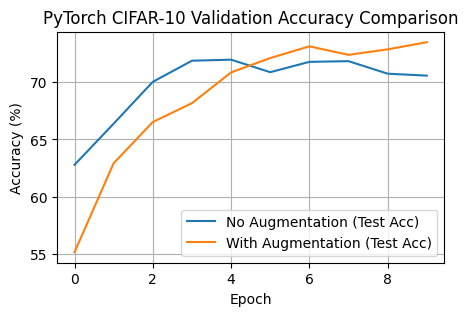


---  최종 비교  ---
**증강 없음 최종 테스트 정확도: 70.56%**
**증강 적용 최종 테스트 정확도: 73.47%**


In [9]:
# 결과 시각화
plt.figure(figsize=(5, 3))
plt.plot(val_acc_no_aug, label='No Augmentation (Test Acc)')
plt.plot(val_acc_with_aug, label='With Augmentation (Test Acc)')
plt.title('PyTorch CIFAR-10 Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

print("\n---  최종 비교  ---")
print(f"**증강 없음 최종 테스트 정확도: {final_acc_no_aug:.2f}%**")
print(f"**증강 적용 최종 테스트 정확도: {final_acc_with_aug:.2f}%**")